In this project, we will use the dataset with images centered around a single digit (many of the
images do contain some distractors at the sides). Although we are taking a sample of
the data which is simpler, it is more complex than MNIST because of the distractors.

The Street View House Numbers (SVHN) Dataset
SVHN is a real-world image dataset for developing machine learning and object
recognition algorithms with the minimal requirement on data formatting but comes from a
significantly harder, unsolved, real-world problem (recognizing digits and numbers in
natural scene images). SVHN is obtained from house numbers in Google Street View
images.
Link to the dataset:
https://drive.google.com/file/d/1L2-WXzguhUsCArrFUc8EEkXcj33pahoS/view?usp=sharing

Yuval Netzer, Tao Wang, Adam Coates, Alessandro Bissacco, Bo Wu, Andrew Y. Ng
Reading Digits in Natural Images with Unsupervised Feature Learning NIPS Workshop
on Deep Learning and Unsupervised Feature Learning 2011.

The objective of the project is to learn how to implement a simple image classification pipeline
based on a deep neural network. The goals of this project are as follows:

### ● Understand the basic Image Classification pipeline and the data-driven approach (train/predict stages)

In [39]:
import tensorflow as tf
print (tf.__version__)
tf.random.set_seed(100)
tf.keras.backend.clear_session()

2.2.0


In [41]:
import h5py
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout #Creating a Dense DNN
from tensorflow.keras.constraints import MaxNorm

### ●  Data fetching and understand the train/test splits. (5 points)

In [43]:
h5f = h5py.File('/Users/debajyotidas/Google Drive/PGP-AIML/Neural Networks & Deep Learning/Project 1/SVHN_single_grey1.h5','r')
X_train = h5f['X_train'][:]
ytrain = h5f['y_train'][:]
X_test = h5f['X_test'][:]
ytest = h5f['y_test'][:]
h5f.close()

In [45]:
X_train.shape

(42000, 32, 32)

In [46]:
X_test.shape

(18000, 32, 32)

In [47]:
X_train[1]

array([[86.9591, 87.0685, 88.3735, ..., 91.8014, 89.7477, 92.5302],
       [86.688 , 86.9114, 87.4337, ..., 90.7306, 87.204 , 88.5629],
       [85.9654, 85.8145, 85.9239, ..., 63.8626, 59.8199, 54.8805],
       ...,
       [90.2236, 91.0448, 93.4637, ..., 55.3535, 48.5822, 44.0557],
       [90.6427, 90.4039, 90.937 , ..., 78.2696, 77.4977, 74.27  ],
       [88.0236, 88.1977, 86.6709, ..., 75.2206, 76.6396, 79.2865]],
      dtype=float32)

In [48]:
ytrain.shape

(42000,)

In [49]:
ytrain[0:5]

array([2, 6, 7, 4, 4], dtype=uint8)

In [50]:
y_train = keras.utils.to_categorical(ytrain, 10)
y_test = keras.utils.to_categorical(ytest, 10)

In [51]:
print(y_train.shape)
print('First 5 examples now are: ', y_train[0:5])

(42000, 10)
First 5 examples now are:  [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


### ● Implement and apply a deep neural network classifier (including feedforward neural network, RELU, activations) (10 points)

In [170]:
# Initialize the constructor
model1 = Sequential()

# Define model architecture
lrelu = lambda x: tf.keras.layers.LeakyReLU(alpha=0.8)(x)
model1.add(tf.keras.layers.Reshape((1024,),input_shape=(32,32,)))
#model1.add(Dense(256, activation='relu',input_shape=(1024,)))
model1.add(Dense(1024, activation=lrelu))
model1.add(Dropout(0.2))
model1.add(Dense(1024, activation=lrelu))
model1.add(Dropout(0.2))
model1.add(Dense(1024, activation=lrelu))
#model1.add(Dropout(0.2))
model1.add(Dense(10, activation = 'softmax'))

model1.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_27 (Reshape)         (None, 1024)              0         
_________________________________________________________________
dense_98 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_29 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_99 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_30 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_100 (Dense)            (None, 1024)              1049600   
_________________________________________________________________
dense_101 (Dense)            (None, 10)              

In [171]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model1.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

Model accuracy : 0.691944420337677


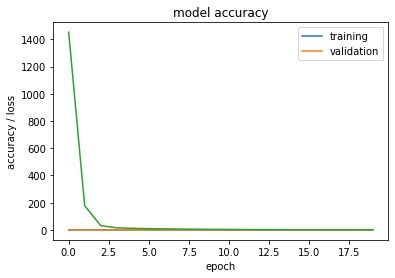

In [172]:
history = model1.fit(X_train, y_train, epochs=20, batch_size=1000, validation_split=.1, verbose=0)
loss,accuracy  = model1.evaluate(X_test, y_test, verbose=0)
print("Model accuracy :" , accuracy)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy / loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

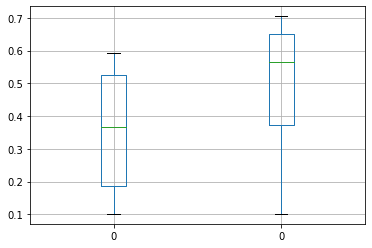

In [173]:
ta = pd.DataFrame(history.history['accuracy'])
va = pd.DataFrame(history.history['val_accuracy'])
tva = pd.concat([ta,va] , axis=1)

tva.boxplot()

#### *Without normalization of data, we require a very complicated model to achieve some sort of respectable score. For such a model, the training time & resource consumption during training is extremely large. Moreover, the model is not well generalized as can be seen from the above box-plots, wherein the training & validation accuracy scores are not similar.*
### *We will see below if Normalization can help us build a much simpler model*

### ● Implement batch normalization for training the neural network (5 points)

In [80]:
model2 = Sequential()

#lrelu = lambda x: tf.keras.layers.LeakyReLU(alpha=0.05)(x)
#model2.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model2.add(tf.keras.layers.Reshape((1024,),input_shape=(32,32,)))
#model2.add(Dense(256, activation='relu', input_shape=(1024,)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(Dense(256, activation='relu', ))
model2.add(Dense(10, activation='softmax'))

model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 1024)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_12 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_13 (Dense)             (None, 10)                2570      
Total params: 269,066
Trainable params: 267,018
Non-trainable params: 2,048
_________________________________________________________________


In [81]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

Model accuracy : 0.8387777805328369


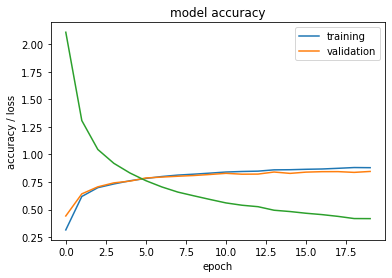

In [82]:
history = model2.fit(X_train, y_train, 
                     epochs=20, 
                     batch_size=1000, 
                     validation_split=.1,
                     verbose=0)
loss,accuracy  = model2.evaluate(X_test, y_test, verbose=0)
print("Model accuracy :" , accuracy)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy / loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

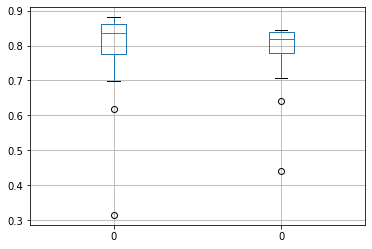

In [83]:
ta = pd.DataFrame(history.history['accuracy'])
va = pd.DataFrame(history.history['val_accuracy'])
tva = pd.concat([ta,va] , axis=1)

tva.boxplot()

#### *We can now see that Batch Normalization has helped us achieve a very simple but robust model with comparable performance during both Training & Validation. This model shows an almost 21% points improvement in Testing accuracy over our earlier complex Neural Network. The same performance can be achieved by using other scaling techniques like Z-Scoring/StandardScaler also*

### ● Print the classification accuracy metrics (Print Both Classification report and Confusion Matrix) (10 points)

In [84]:
y_predict = model2.predict(X_test)
y_pred = []
for val in y_predict:
    y_pred.append(np.argmax(val))
cm = metrics.confusion_matrix(ytest,y_pred)
print(cm)

[[1569   35   12   28   17    4   40   23   39   47]
 [  25 1566   19   42   51   10   16   43   37   19]
 [  17   24 1504   45   26   17    6   58   49   57]
 [  23   24   22 1360   18  128   17   35   65   27]
 [  27   43   25   25 1541   17   38   12   36   48]
 [  16   16    9   80   13 1484   54    9   48   39]
 [  57   30   16   19   30   71 1448   12  127   22]
 [  22   63   34   20    9   11   10 1588   21   30]
 [  32   35   16   55   10   30   55    5 1519   55]
 [  42   34   21   44   14   45   10   21   54 1519]]


In [85]:
cr=metrics.classification_report(ytest,y_pred)
print(cr)

precision    recall  f1-score   support

           0       0.86      0.86      0.86      1814
           1       0.84      0.86      0.85      1828
           2       0.90      0.83      0.86      1803
           3       0.79      0.79      0.79      1719
           4       0.89      0.85      0.87      1812
           5       0.82      0.84      0.83      1768
           6       0.85      0.79      0.82      1832
           7       0.88      0.88      0.88      1808
           8       0.76      0.84      0.80      1812
           9       0.82      0.84      0.83      1804

    accuracy                           0.84     18000
   macro avg       0.84      0.84      0.84     18000
weighted avg       0.84      0.84      0.84     18000



#### *As can be seen from the above,  Batch or any other form of normalization of data, increases model efficiency extremely. Without normalization, the model is unable to learn any pattern within the specified epochs & both the training & validation curves are flat from begining. Thus at least some form of scaling (StandardScaler/Z-Score or MinMaxScaler) is needed to be able to train the model.*

#### *We have tried StandardScaler & BatchNormalization between hidden layers in conjenction & have observed that BatchNormalization alone was capable of handling normalization & hence both were not needed in tandem.It infact reduced the model efficiency & we thus proceeded with BatchNormalization alone.*

#### *We tried multiple combinatons of neurons & number of hidden layers & observed that 1 hidden layer with 256 neurons provided the most stable & optimum performance. With more neurons/layers, there was not much improvement in accuracy, while the model stability fell.*

#### *As there were not many layers/neurons, we didn't go for drop-out.*

#### *We tried multiple combinations of batch size & epochs & discovered that an epoch of 20, helped achieve both smooth learning curves across training & validation. We tried batch sizes of 21000-10500-7000-3000-1000 & observed that 1000 offered the best accuracy with a stable model. The training & validation curves were not wavy & the curves had flattened out within the provided number of epochs.*

#### *As the number of epochs were small, we didn't opt for Early Stopping.*

#### *We tried different activation functions and found that ReLU gave the best performance, in spite of using Batch Normalization which could have caused Vanishing Gradient problem. Of the rest, Leaky ReLU with alpha of 0.05 provided similar results, while Tanh & Sigmoid showed very poor performance, even after using BatchNormalization/Z-Scoring.*

#### *Of the different optimizers used, Adam showed the most promising results with default parameters. Of the rest, AdaDelta & NAG fared very poorly. AdaGrad & RMSProp were similar, but offered less accuracy than ReLU.*

#### *We have also tried using He weight initialization, as the activation function was ReLU, but observed that there was no considerable improvement in the model accuracy over the default Glorot initialization*